This tutorial showcases how to obtain wavescapes from real audio data. As it is the second notebook in a series of three, we recommand you to follow the previous one "1. Single Wavescape" before delving into this one, as parameters presented previously are used here without much explanations.

The goal of this tutorial is only to show you how to use the library; for explanations of the visualization's methodology and how to interpret wavescapes, please refer to [the official publication from Musicae Scientiae (dead link as it is not yet published)](dead)

If you plan on running this notebook on your computer, be sure the module "wavescapes" and all its dependencies are properly installed on your machine or virtual environnement ( `pip install wavescapes`). ( _Note for DCML users tests: step not required as long as you are running this notebook on a local clone of the repo_ ). Run the cell below to check if the module was properly installed. 

In [1]:
'''
The shell line below will be removed once the last version of the library 
is publicly available through pip. Its purpose for now is just to redirect
the source code of the repo in the same place as this notebook.
'''
!ln -s ../wavescapes wavescapes

from wavescapes import single_wavescape

ln: wavescapes/wavescapes: File exists


## Table of Content

1. [Audio processing backend & Formats supported](#backend)
2. [Base case and ticks for seconds](#base)
2. [CLP vs. Deep Chroma](#dc)
4. [Boosting](#boosting)

Throughout this tutorial, two audio files are used to demonstrate wavescapes on audio data. They are also accompanied by two correspnding XML transcriptions acting as reference points to judge the performance of the audio processing. The two pieces chosen for the needs of this tutorial are the following:

1. [A string quartet recording](https://imslp.org/wiki/Special:ReverseLookup/84547) by the "Steve's Bedroom Band" of the first of the two Arabesques by Claude Debussy (L. 66) made publicly available under the Creative Common Attribution 3.0 License. Its [XML counterpart can be found here](https://musescore.com/classicman/scores/55396), but has been transposed to the key of F Major so that it shares the tonality.
2. [An orchestral recording](https://imslp.org/wiki/Special:ReverseLookup/246990) by the "Czech National Symphony Orchestra" of the fourth movement of the Peer Gynt Suite No. 1 Op.46 by Edvard Grieg (which is more commonly known in the pop culture under the name "In the Hall of the Mountain King") made publicly available under the Creative Common Attribution 3.0 License. Its [XML counterpart can be found here](https://musescore.com/user/1580161/scores/4836471).

In [2]:
import os

def test_file_existence(filepath):
    if not os.path.isfile(filepath):
        raise Exception("'%s' does not exist."%filepath)

arabesque_audio = 'inputs/IMSLP84547-PMLP02383-T02_debussy_arabesque.mp3'
arabesque_xml = 'inputs/Arabesque_L._66_No._1_in_F_Major.musicxml'
mk_audio = 'inputs/IMSLP246990-PMLP02533-Peer_Gynt_Suite_No._1,_Op._46_-_IV._In_the_Hall_Of_The_Mountain_King.mp3'
mk_xml = 'inputs/In_the_Hall_of_the_Mountain_King.mxl'

for f in [arabesque_audio, arabesque_xml, mk_audio, mk_xml]:
    test_file_existence(f)

When it comes to producing wavescapes, the main difference between audio and symbolic data is the way pitch-class content is retrieved from the input. This process is trivial for symbolic data, but quite complex for audio, and as such, it deserves to be tackled separately in its own notebook. 

<a id='backend'></a>
## 1. Audio processing backend & Formats supported

The`wavescapes` library uses the [madmom](https://github.com/CPJKU/madmom) python library as its audio backend. `madmom` is only used to retrieve pitch-class vectors (or chromagrams) from the audio signal. By default, `madmom` natively support audio files in WAV format, but almost all existing audio formats can be supported if [ffmpeg](https://ffmpeg.org/) is properly installed on your machine. As the two audio files used in this tutorial are in `mp3`, `ffmpeg` is required for running all cells from this notebook. 

<a id='base'></a>
## 2. Base case and ticks for seconds

Pitch-class vectors are used to build the wavescape without any consideration of their source, whether its from symbolic or audio data. As such, with the exception of `removing_unpitched_tracks`, all parameters introduced in the previous notebook works the same way on audio input.

Performing wavescape on audio is pretty simple, you just need to provide the path of an audio file to the `single_wavescape` function, the library checks the file extension to decide whether to process audio or symbolic data. The cell below generates the wavescapes on the 5th coefficient on the quartet recording of Debussy's Arabesque:

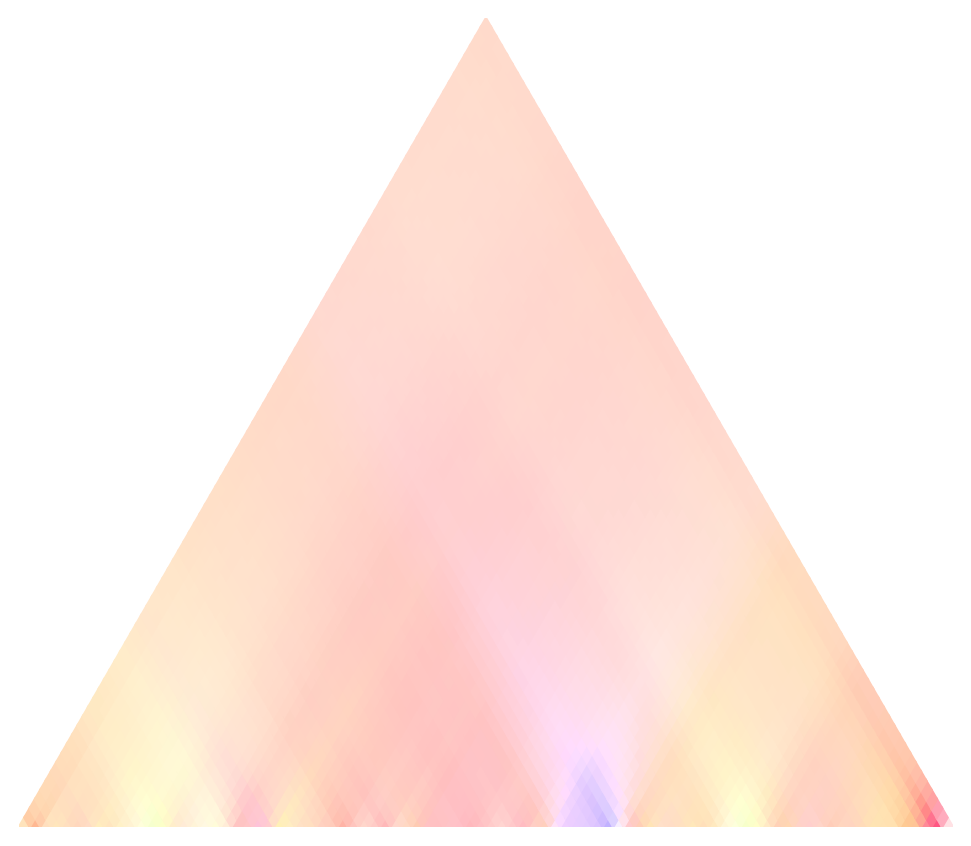

In [3]:
single_wavescape(arabesque_audio, 500, coefficient=5,  aw_size=3)

The argument `aw_size` still holds the function of specifying the length of the shortest segment of the wavescape, but its unit is expressed in seconds instead of quarter notes. The parameters `tick_ratio` and `tick_factor` can be used to draw ticks that represent the seconds of the recording (without setting any value to `tick_offset` so that the tick numbers start at 0):

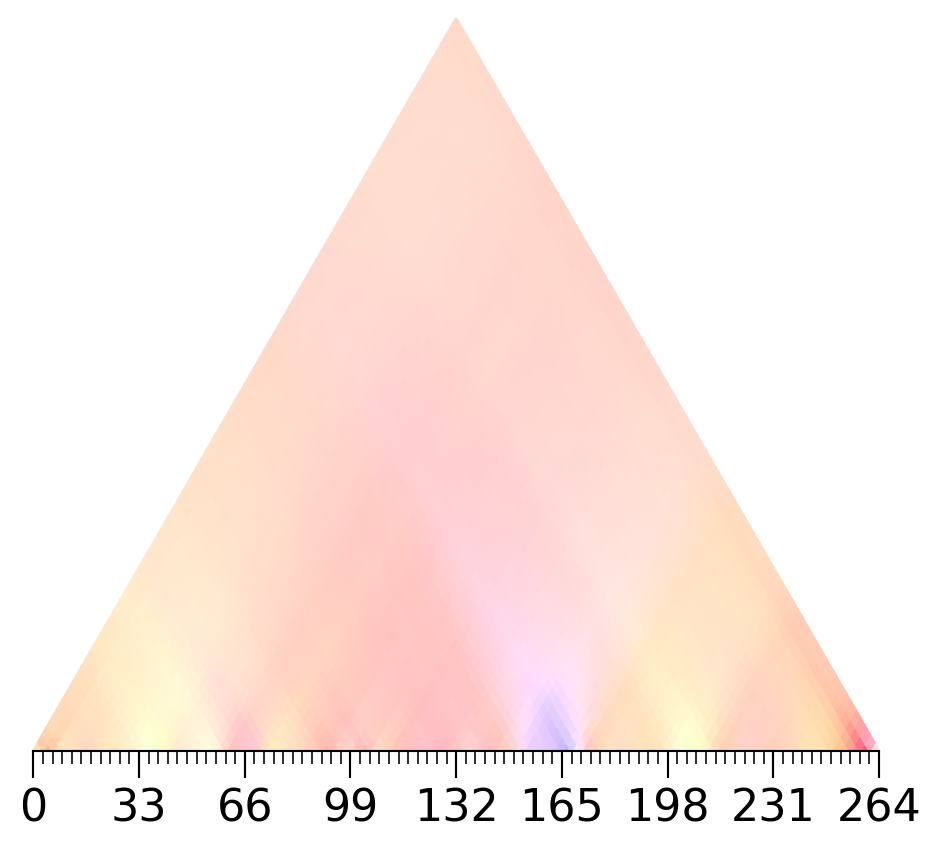

In [4]:
single_wavescape(arabesque_audio, 500, coefficient=5,  aw_size=3,\
                 tick_ratio=1, tick_factor=3)

Although the plot produced is readable, the colors are quite faded away. Without knowledge of the tonality of the piece, it is hard to know whether the color appears faded because the tonality of the piece does not resonate well with Fourier's 5th coefficient, or because the chromagram production process had trouble extracting the relevant pitch content. 

Fortunately, we can use the XML transcript as a way to check the accuracy of the audio processing, below is a function that display wavescape from symbolic and audio data next to each other in order to compare them:

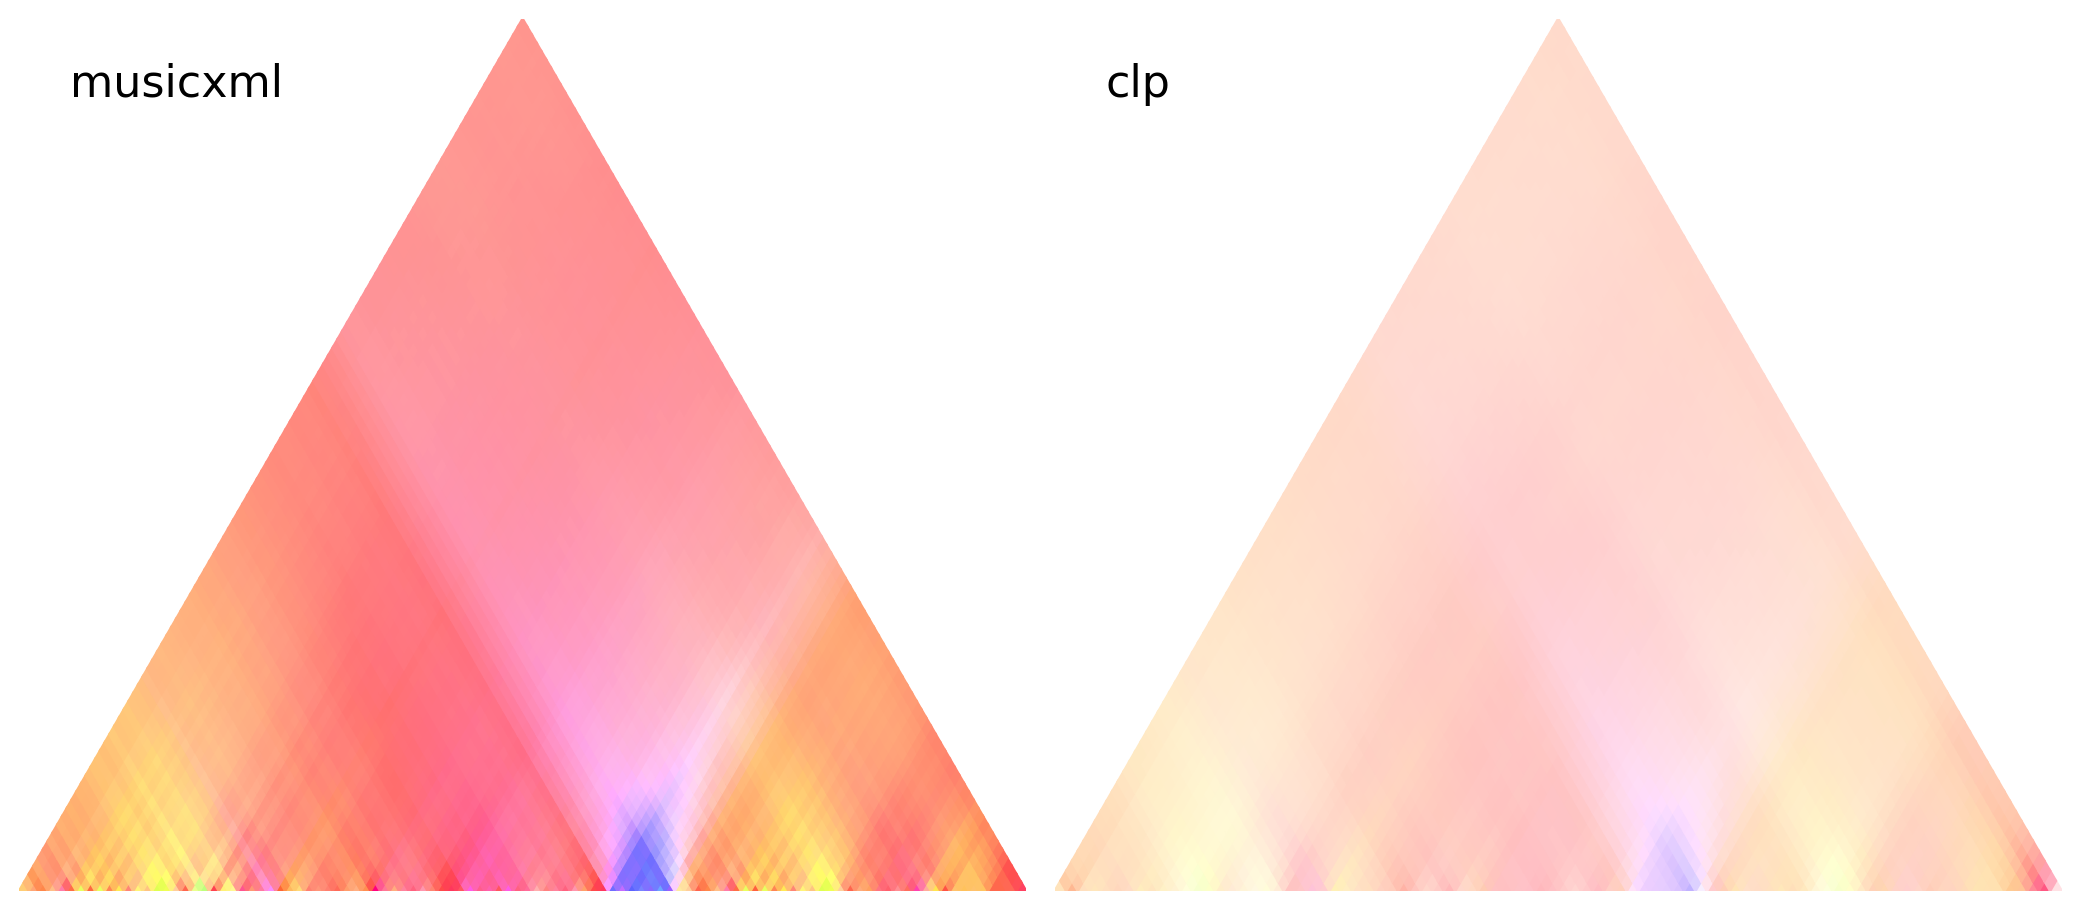

In [5]:
import matplotlib.pyplot as plt
#aw size choseon so both files are cuts in roughly 100 segments
arabesque_xml_aw = 4 #106.1 bars * 4 == 425 quarter notes in length
arabesque_mp3_aw = 3 #4:21 == 261s

def symbolic_vs_audio(sym_fp, audio_fp, sym_aw, audio_aw, indiv_width, coefficient, deep_chroma=False, boosting=False):
    dpi = 96
    total_width = (2.1*indiv_width)/dpi
    #height compute_plot_height
    sym_label = sym_fp.split('.')[-1]
    audio_label = ('dc' if deep_chroma else 'clp') + ('_boost' if boosting else '')
    fig = plt.figure(figsize=(total_width, indiv_width/dpi), dpi=dpi)
    
    ax1 = fig.add_subplot(1,2,1, aspect='equal')
    single_wavescape(sym_fp, indiv_width, coefficient=coefficient, aw_size=sym_aw, ax=ax1, label=sym_label)
    
    magn_stra = 'boost'if boosting else '0c'
    ax2 = fig.add_subplot(1,2,2, aspect='equal')
    single_wavescape(audio_fp, indiv_width, coefficient=coefficient, aw_size=audio_aw, ax=ax2, label=audio_label, deep_chroma=deep_chroma, magn_stra=magn_stra)

symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5)

Although the hue seems to be generally consistent between the two versions of the Arabesque, we can indeed confirm the lack of opacity seems to be an issue with the audio processing.

<a id='dc'></a>
## 3. CLP vs Deep Chroma

Two methods of retrieval of chromagrams proposed by madmom are implemented in the wavescapes library:

1. The **Compression Log Pitch (CLP)** Chroma Processor (default one)
2. The **Deep Chroma** Processor

By default, the CLP Chroma Processor is used, all the plots above were produced using this process. The Deep Chroma Processor uses a pre-trained deep neural network to help extract harmonic features from an audio signal. To switch from the CLP to the Deep Chroma processor, the boolean parameter `deep_chroma` from `single_wavescape` can be set to the value `True`. Here is how the visual result changes by enabling the deep_chroma processor on the previous example:

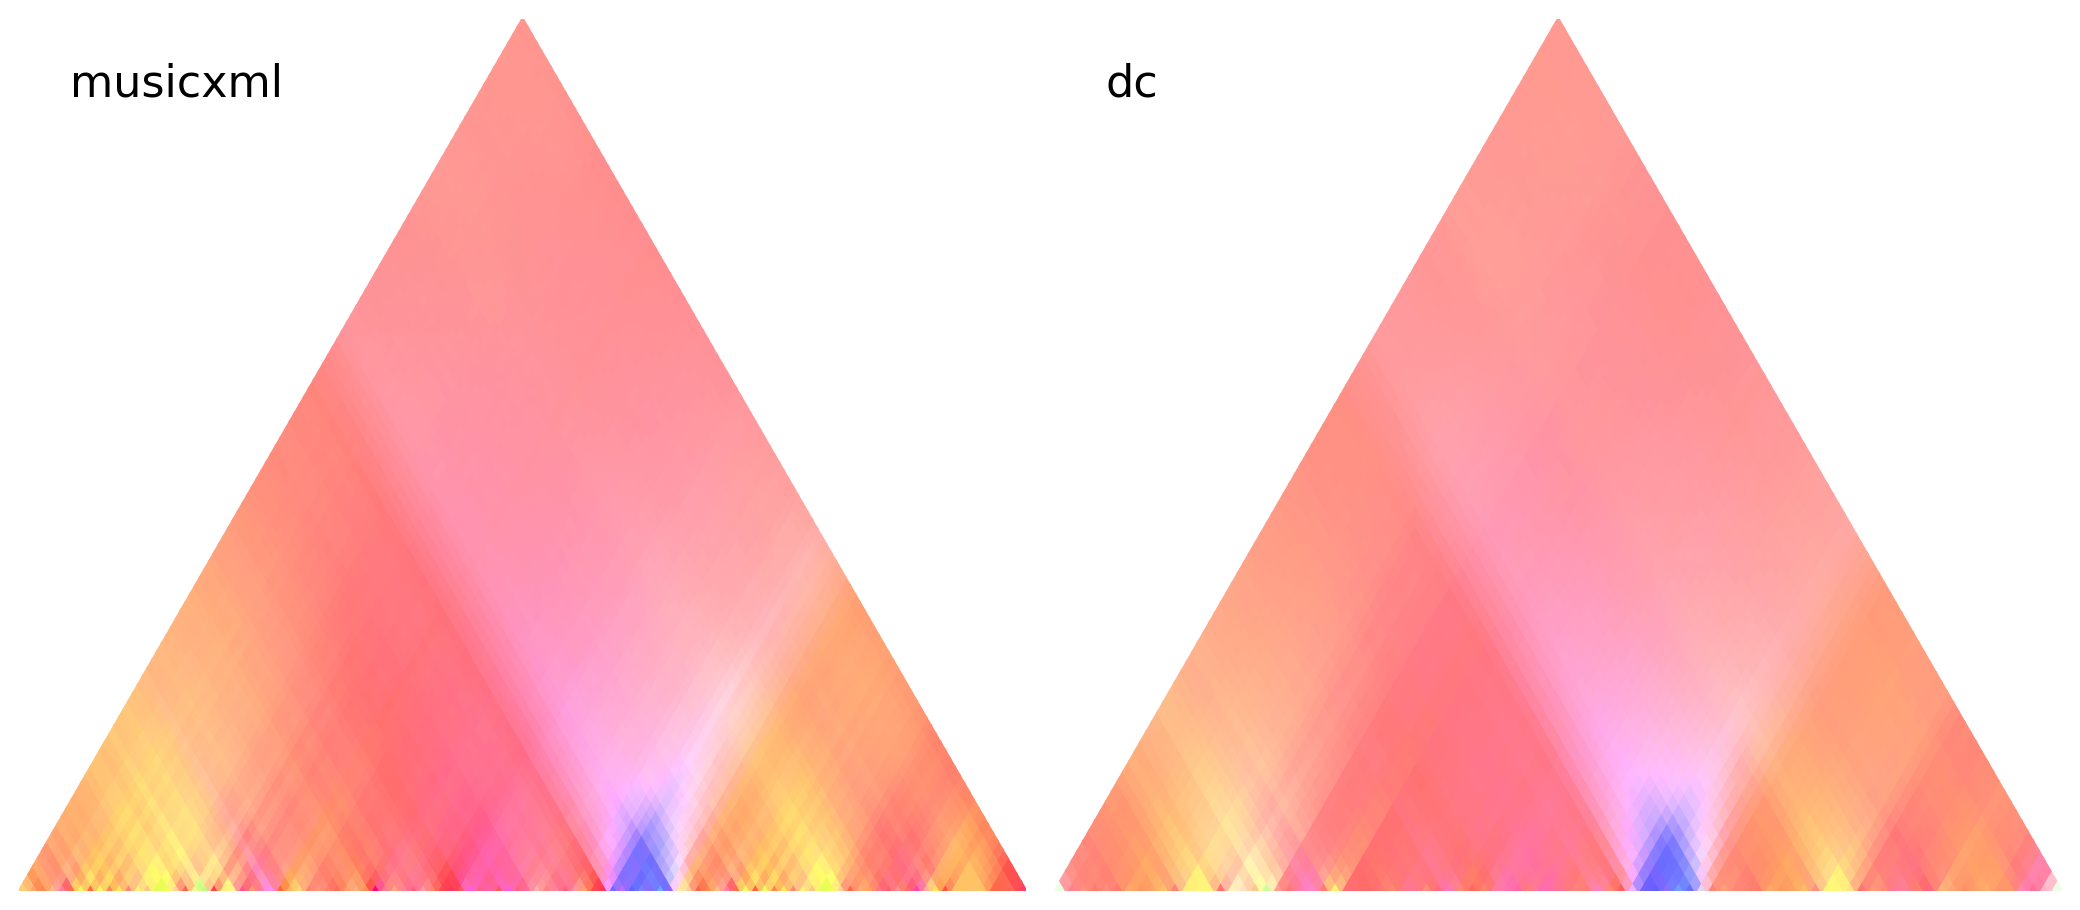

In [6]:
symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5, deep_chroma=True)

The visual quality is much better, even comparable to the quality achieved by symbolic data input. Often the Deep Chroma processor performs better than the CLP, although it really depends on the input signal. Generally, the Deep Chroma performs the best on pieces with percussions, such as "In the hall of the mountain King":

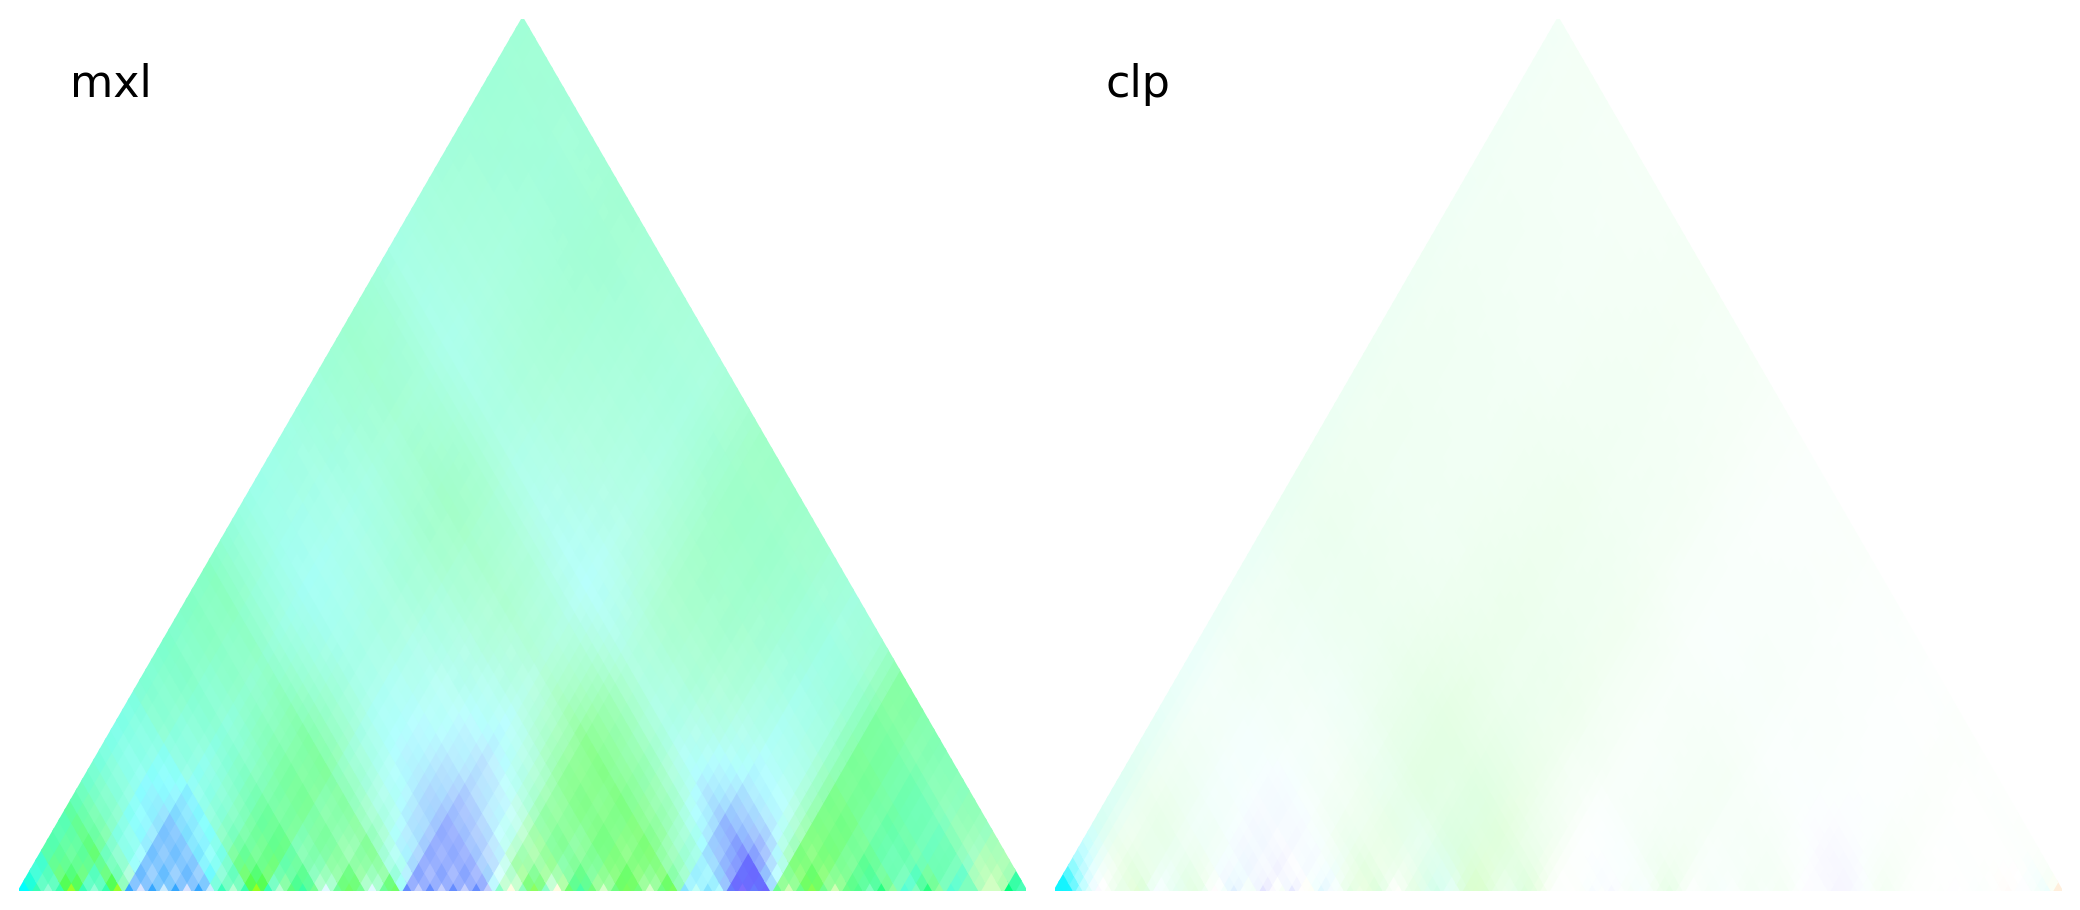

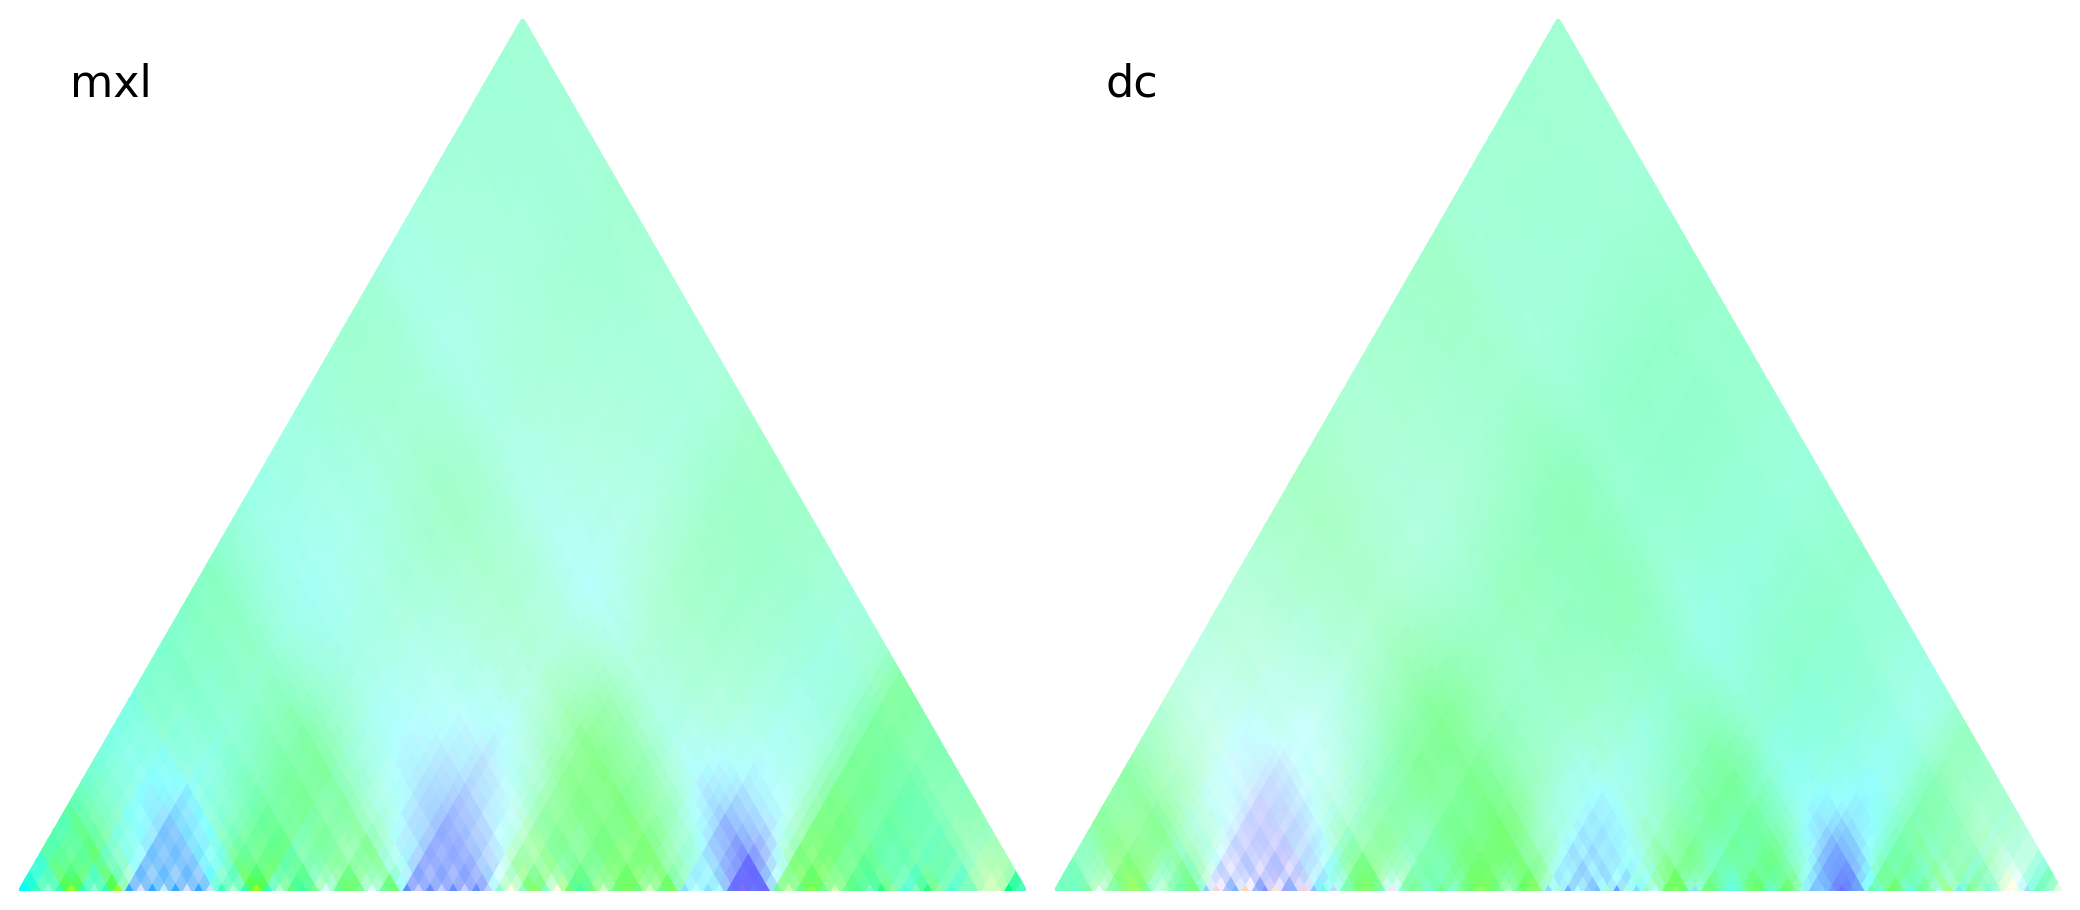

In [7]:
mk_xml_aw = 4 #87 bars * 4 == 348 quarter notes in length
mk_mp3_aw = 1.5 #2:34 == 154s
symbolic_vs_audio(mk_xml, mk_audio, mk_xml_aw, mk_mp3_aw, 500, 5)
symbolic_vs_audio(mk_xml, mk_audio, mk_xml_aw, mk_mp3_aw, 500, 5, deep_chroma=True)

For this piece, the CLP method is practicaly fruitless while the Deep Chroma processor brings the quality close to the MXL version, although not quite exactly to the same level of closeness that was achieved on the Arabesque in terms of opacity. Fortunately there is one last paramter we can use to improve the visual quality:

<a id='boosting'></a>
## 4. Boosting

Even through the wonders of the Deep Chroma processor, it is unlikely that a pitch-class vector derived from audio data can actually reach a normalized magnitude value of 1 (which visually corresponds to the maximum possible opacity) for any coefficient. However any wavescapes on audio has at least one element reaching a maximum value of normalized magnitude,$\mu_m$, such that $0 \leq \mu_m \lt 1$. This implies that all the opacity values corresponding to magnitudes above this maximum are not "used" in the plot. What we call `boosting` is setting this maximum observed value of magnitude to the maximal opacity instead, thus "boosting" all magnitudes by multiplying them by a factor of $\frac{1}{\mu_m}$. This means the maximum opacity is reached by at least one of the elements from the wavescape (the one with value $\mu_m$, since $\frac{1}{\mu_m} * \mu_m = 1$).

The parameter `magn_stra` from `single_wavescape` represents the _magnitude_ _strategy_ for wavescapes and can receive different string parameters. For now, we are interested only by two of them, `0c` (the default one, stands for '0th coefficient') and `boost`, which achieves the processus of boosting the magnitude as described previously:

/Users/cedricviaccoz/wavescapes/tutorials/wavescapes/color.py:212: UserWarning: Max magnitude of 0.598082 observed for coeff. number 5, boosting all magnitudes by 167.20% of their original values
  warn(msg)


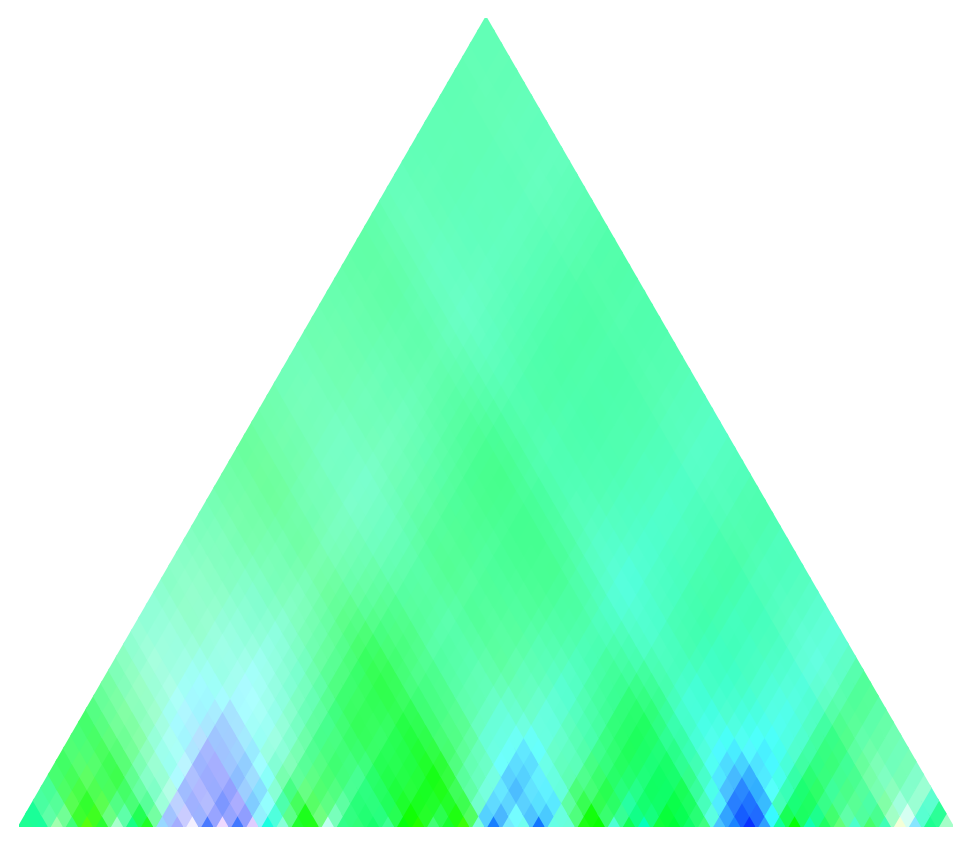

In [8]:
single_wavescape(mk_audio, 500, coefficient=5,  aw_size=2.5, magn_stra='boost', deep_chroma=True)

Each time this parameter is used with the value `'boost'`, an UserWarning is issued to report the maxmimal magnitude observed, and by how much all the magnitudes are boosted. In this case, all the magnitudes were boosted by 167% from their original value.

We can also try boosting on the CLP version:

/Users/cedricviaccoz/wavescapes/tutorials/wavescapes/color.py:212: UserWarning: Max magnitude of 0.915704 observed for coeff. number 5, boosting all magnitudes by 109.21% of their original values
  warn(msg)


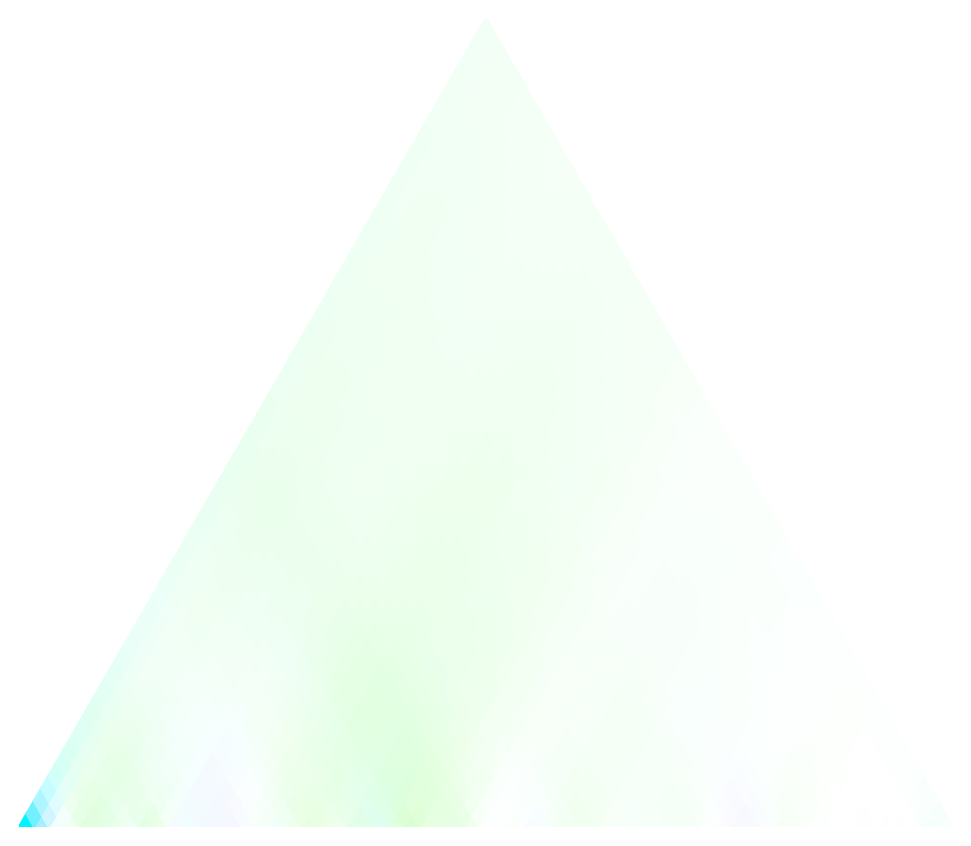

In [9]:
single_wavescape(mk_audio, 500, coefficient=5,  aw_size=2.5, magn_stra='boost', deep_chroma=False)

As the maximal magnitude is already really close to 1, bossting does not improve the visual quality by much.

Although always "boosting" the wavescapes might be tempting, this is a process that fundamentally alters the perception we have of the tonality of pieces through wavescapes, and as such, should be used on audio data only when it is not possible to obtain readable visual results otherwise. For instance, using "boosting" on the deep chroma processed Arabesque actually "overdrives" the color values:

/Users/cedricviaccoz/wavescapes/tutorials/wavescapes/color.py:212: UserWarning: Max magnitude of 0.628007 observed for coeff. number 5, boosting all magnitudes by 159.23% of their original values
  warn(msg)


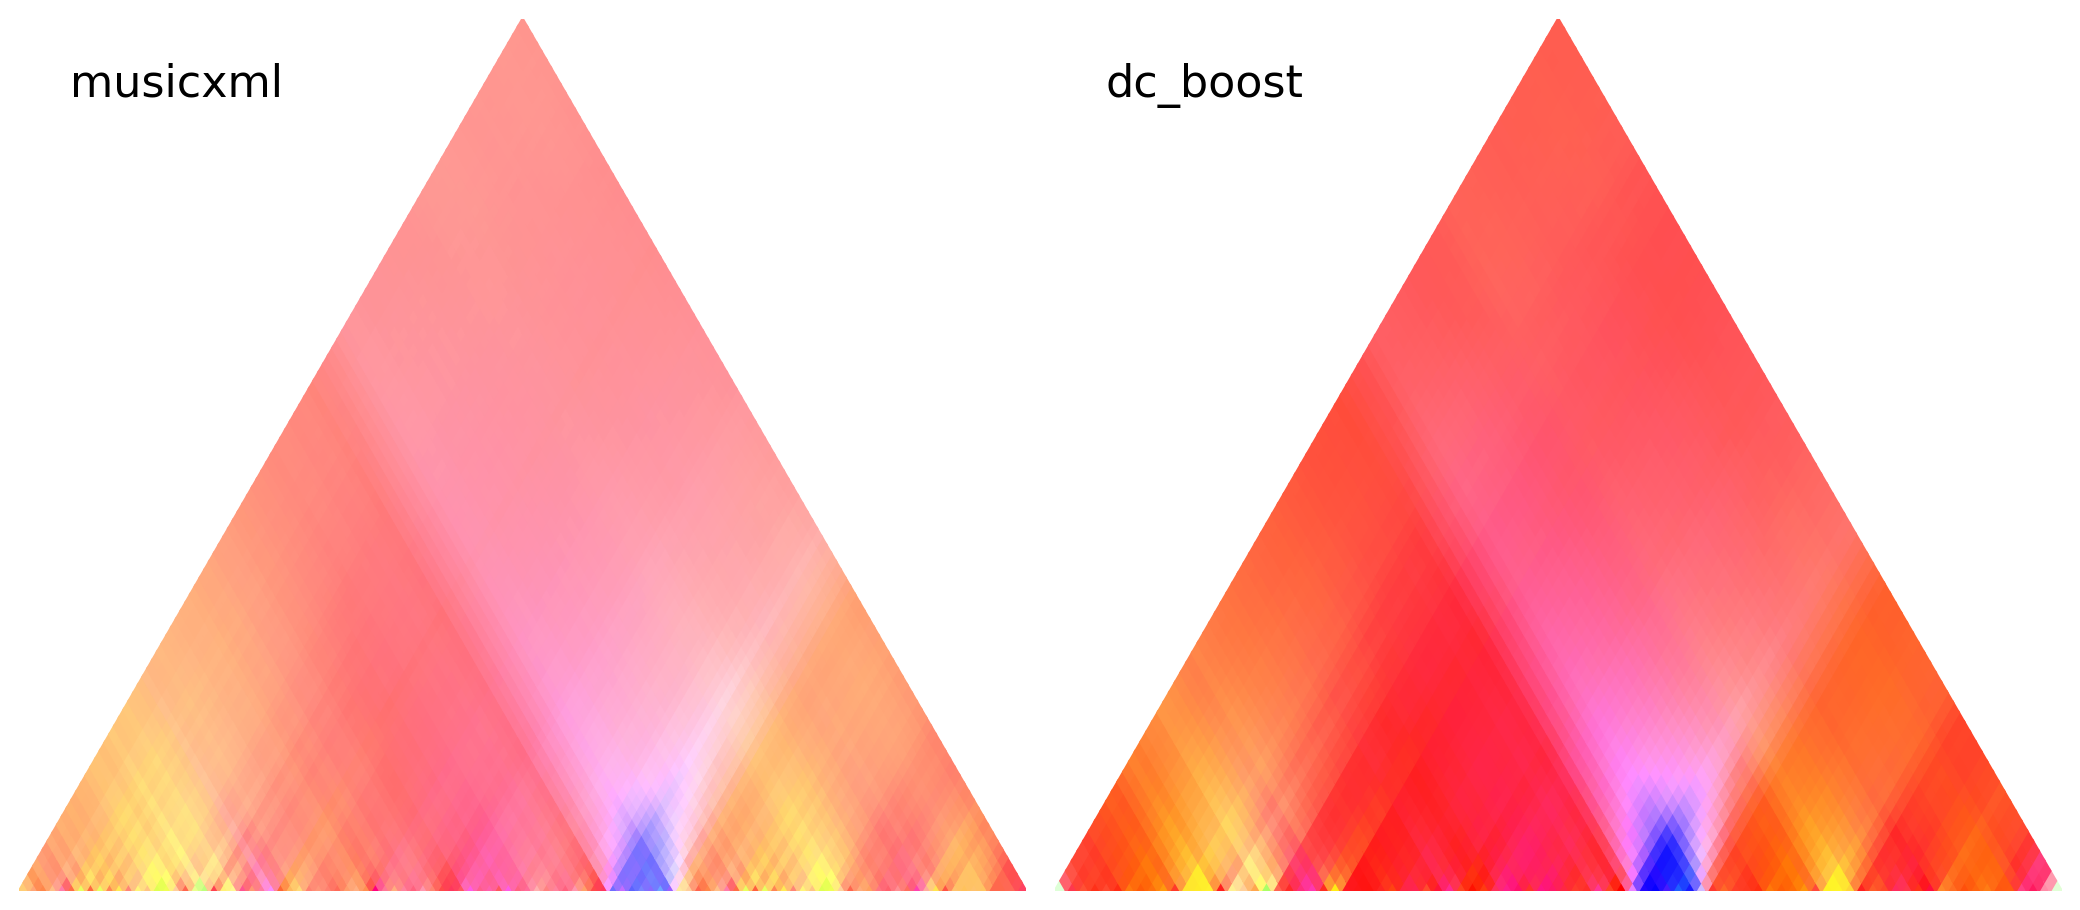

In [10]:
symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5,\
                  deep_chroma=True, boosting=True)

The fact that the colors do not reach the maximal opacity value on the reference XML transcription is actually an information about the tonality of the Arabesque; an information that gets lost when boosting is used on the deep chroma processed audio. However, using it on the CLP processsed audio actually brings its visual quality a bit closer to the reference figure:

/Users/cedricviaccoz/wavescapes/tutorials/wavescapes/color.py:212: UserWarning: Max magnitude of 0.661403 observed for coeff. number 5, boosting all magnitudes by 151.19% of their original values
  warn(msg)


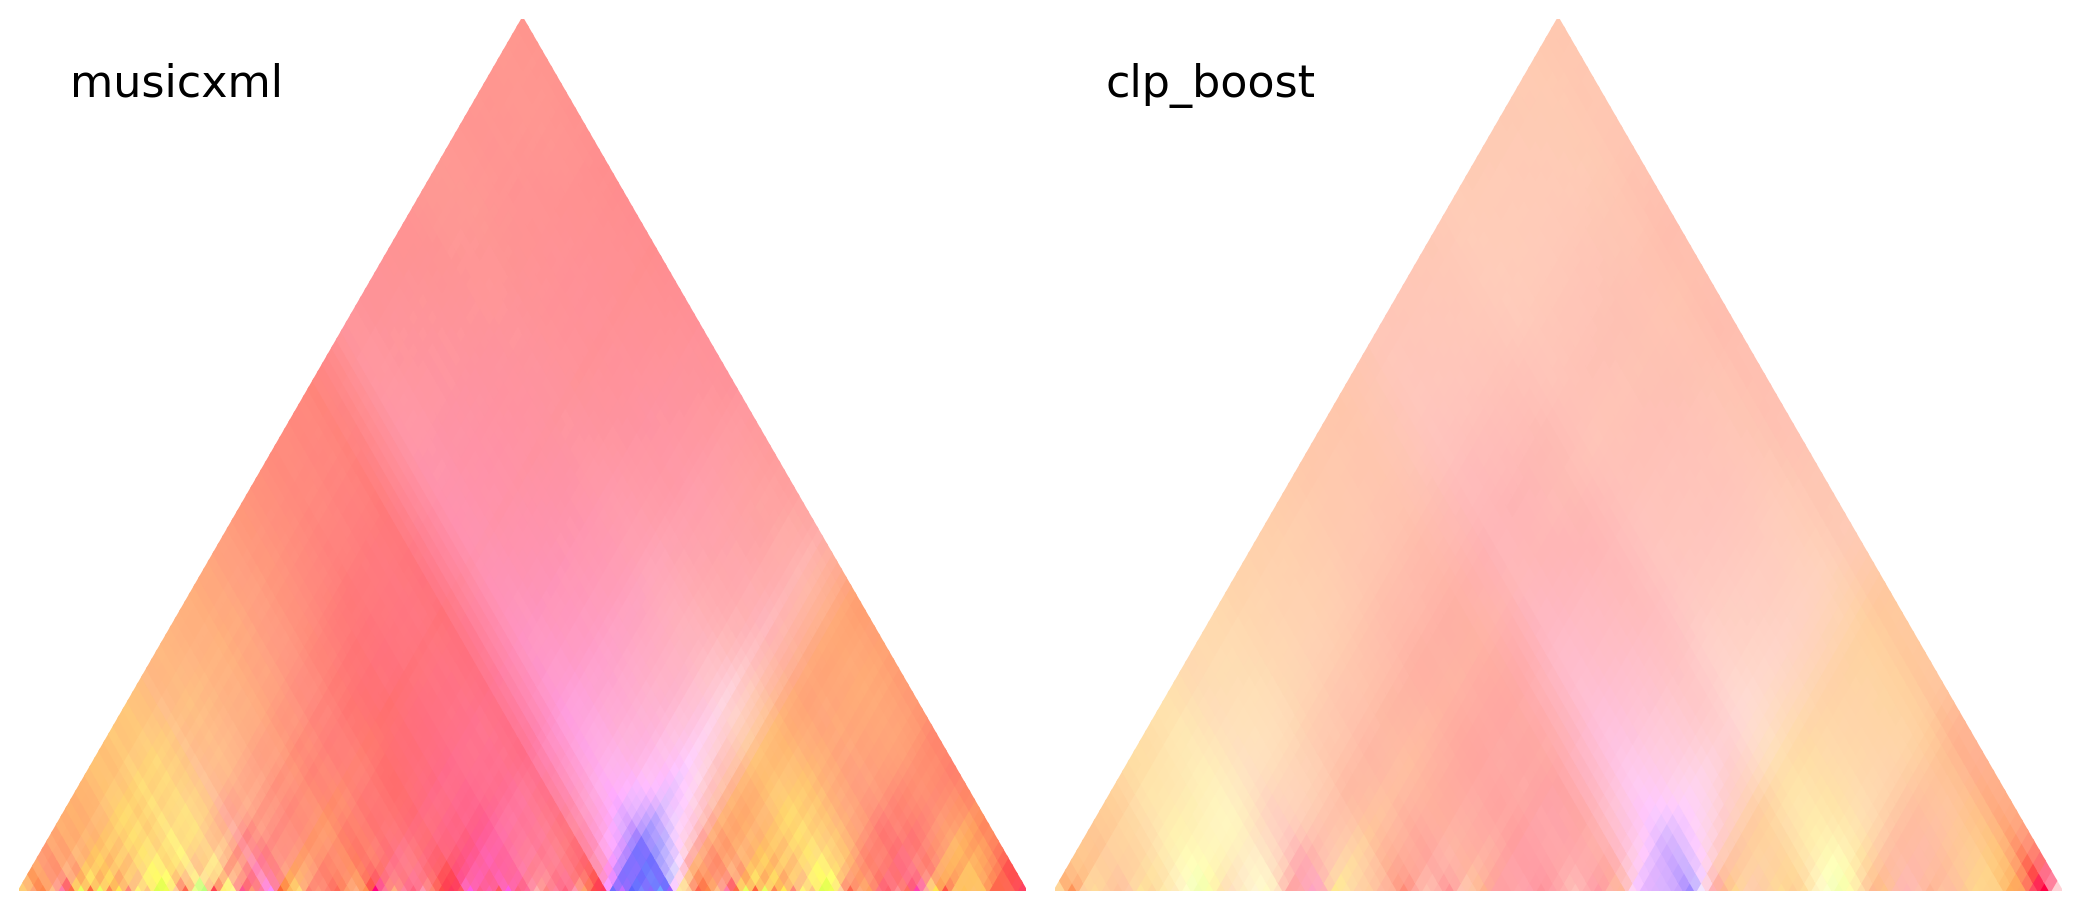

In [11]:
symbolic_vs_audio(arabesque_xml, arabesque_audio, arabesque_xml_aw, arabesque_mp3_aw, 500, 5, deep_chroma=False, boosting=True)

In the end, audio processing stays a difficult problem in musicology whose solutions can feel like experimenting or even cooking. Audio processing for wavescapes is no exception, thus we recommand you to be careful when using audio files as inputs of the wavescapes library, and try all the different options we offer. If possible, try to have some reference information about the piece and its tonality before producing the plots from an audio source. 